# MONAI Airway Segmentation

In [16]:
import os
from glob import glob
import torch
import time

from monai.transforms import (
    Activations,
    Compose,
    LoadImaged,
    ToTensord,
    AddChanneld,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    EnsureType, 
    AsDiscrete,
)

from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader, decollate_batch
from monai.utils import first
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference


import matplotlib.pyplot as plt

In [17]:
root_dir = "/home/jtabalon/rabbit_seg/"
data_dir = "/home/jtabalon/rabbit_seg/data"

In [18]:
train_images = glob(os.path.join(data_dir, 'train/ct/', 'ct_*.nii'))
train_labels = glob(os.path.join(data_dir, "train/labels/", "aw_*.nii"))

valid_images = glob(os.path.join(data_dir, 'valid/ct/', 'ct_*.nii'))
valid_labels = glob(os.path.join(data_dir, "valid/labels/", "aw_*.nii"))

print(train_images, train_labels)
print(valid_images, valid_labels)

['/home/jtabalon/rabbit_seg/data/train/ct/ct_10004.nii'] ['/home/jtabalon/rabbit_seg/data/train/labels/aw_10004.nii']
['/home/jtabalon/rabbit_seg/data/valid/ct/ct_10242.nii'] ['/home/jtabalon/rabbit_seg/data/valid/labels/aw_10242.nii']


In [19]:
train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
valid_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(valid_images, valid_labels)]

In [20]:
print(train_files)
print(valid_files)

[{'image': '/home/jtabalon/rabbit_seg/data/train/ct/ct_10004.nii', 'label': '/home/jtabalon/rabbit_seg/data/train/labels/aw_10004.nii'}]
[{'image': '/home/jtabalon/rabbit_seg/data/valid/ct/ct_10242.nii', 'label': '/home/jtabalon/rabbit_seg/data/valid/labels/aw_10242.nii'}]


In [21]:
# load the images
# do any transforms
# need to convert into torch tensors

In [37]:
# load the images

train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        #Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2)),
        Spacingd(keys=['image', 'label'], pixdim=(1.0, 1.0, 1.0)),
        #ScaleIntensityRanged(keys='image', a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        Resized(keys=['image', 'label'], spatial_size=[512, 512, 512]),
        ToTensord(keys=['image', 'label']),
    ]
)


valid_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        #Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2)),
        Spacingd(keys=['image', 'label'], pixdim=(1.0, 1.0, 1.0)),
        #ScaleIntensityRanged(keys='image', a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        Resized(keys=['image', 'label'], spatial_size=[512, 512, 512]),
        ToTensord(keys=['image', 'label']),
    ]
)

In [38]:
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

val_ds = Dataset(data=valid_files, transform=valid_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

## Visualize First Patient

In [45]:
#test_patient = first(val_loader)
#print(test_patient)
test_train = first(train_loader)
test_val = first(val_loader)


In [25]:
print(test_train['image'].shape, test_val['image'].shape)

torch.Size([1, 1, 512, 512, 512]) torch.Size([1, 1, 512, 512, 512])


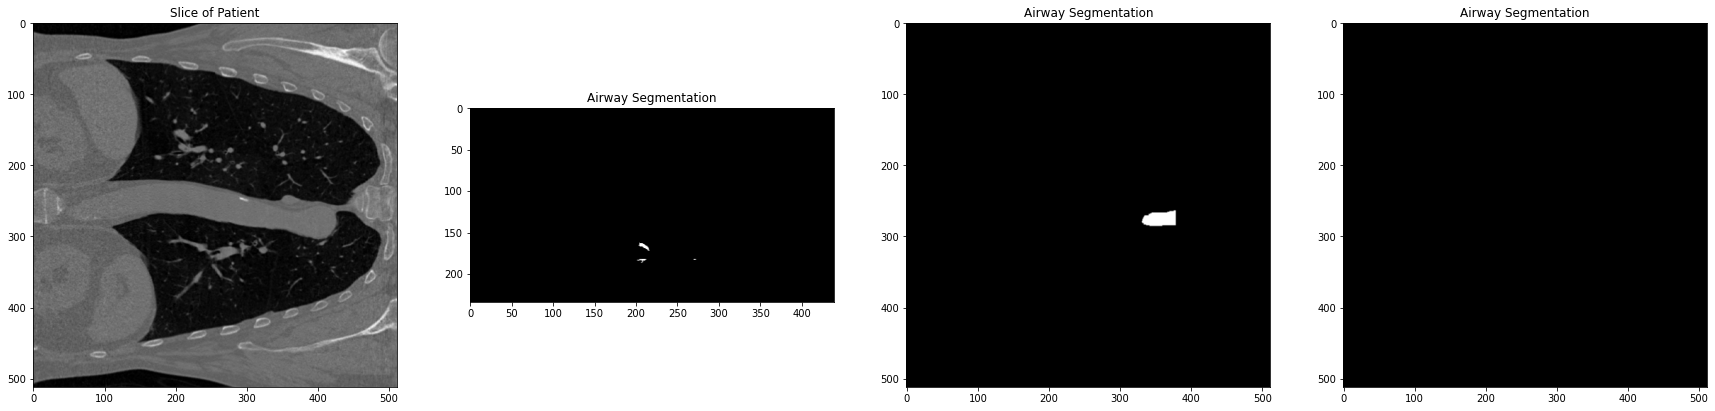

In [26]:
plt.figure('test', (30, 10))


plt.subplot(1, 4, 1)
plt.title('Slice of Patient')
#plt.imshow(test_train['image'][0, 0, :, :, 30], cmap="gray")
#plt.imshow(test_train['image'][0, 0, :, 30, :], cmap="gray")
plt.imshow(test_train['image'][0, 0, 316, :, :], cmap="gray")

plt.subplot(1, 4, 2)
plt.title('Airway Segmentation')
plt.imshow(test_train['label'][0, 0, 316, :234, :439], cmap="gray")

plt.subplot(1, 4, 3)
plt.title('Airway Segmentation')
plt.imshow(test_train['label'][0, 0, :, 234, :], cmap="gray")

plt.subplot(1, 4, 4)
plt.title('Airway Segmentation')
plt.imshow(test_train['label'][0, 0, :, :, 444], cmap="gray")
plt.show()

In [27]:
# Find where - in a given slice - the number of 1s is the highest in order to find the mask of the lungs

In [53]:
import monai

max_epochs = 300
val_interval = 1
VAL_AMP = True

device = torch.device("cuda:1")


net = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=[8, 16, 32],
    strides=[2, 2]
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

optimizer = torch.optim.Adam(net.parameters(), 1e-4, weight_decay=1e-5)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

#Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()

# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True




In [29]:
post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
)

In [30]:
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=net,
            overlap=0.5,
        )
    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


## PyTorch Training Process

In [44]:
def binarize(mask):
    mask['label'][mask['label'] != 0] = 1
    return mask


In [46]:

print(np.unique(test_val['label']))
#test_val['label'][test_val['label'] != 0] = 1
binarize(test_val)
print(np.unique(test_val['label']))


print(np.unique(test_train['label']))
test_train['label'][test_train['label'] != 0] = 1
print(np.unique(test_train['label']))

[0.  0.5 1. ]
[0. 1.]
[0.         0.16666667 0.25       0.33333334 0.5        0.6666667
 0.75       0.8333333  1.        ]
[0. 1.]


In [35]:
import numpy as np

np.unique(test_val['label'])
np.unique(test_train['label'])

array([0.        , 0.16666667, 0.25      , 0.33333334, 0.5       ,
       0.6666667 , 0.75      , 0.8333333 , 1.        ], dtype=float32)

In [56]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()

for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    net.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        batch_data = binarize(batch_data)
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        ) 
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer) 
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        net.eval()
        with torch.no_grad(): #resume here

            for val_data in val_loader:
                val_data = binarize(val_data)
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            print(dice_metric)
            metric_values.append(metric) #
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            #metric_wt = metric_batch[1].item()
            #metric_values_wt.append(metric_wt)
            #metric_et = metric_batch[2].item()
            #metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    net.state_dict(),
                    os.path.join(root_dir, "best_metric_net.pth"),
                )
                print("saved new best metric net")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} "
                  # wt: {metric_wt:.4f} \
                  # et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300
1/1, train_loss: 0.9981, step time: 2.1433
epoch 1 average loss: 0.9981
saved new best metric net
current epoch: 1 current mean dice: 0.0012 tc: 0.0012 
best mean dice: 0.0012 at epoch: 1
time consuming of epoch 1 is: 129.7857
----------
epoch 2/300
